In [67]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit as cf

c = 299792458
h = 6.626e-34
kB = 1.38e-23
T = 8

In [54]:
eta = 0.3 # branching ratio
Delta = 0.5
delta = 0

Gamma_pht = 0.10
OmegaC1 = 0.1
OmegaC3 = 0.1
T1_orb = 46
T1_spin = 170
T2_pure_deph = 20000

In [78]:
a1 = basis(6,0)
a2 = basis(6,1)
b1 = basis(6,2)
b2 = basis(6,3)
c1 = basis(6,4)
c2 = basis(6,5)

HintC1 = OmegaC1/2*(a1*c2.dag() + c2*a1.dag()) 
HintC3 = OmegaC3/2*(a2*c2.dag() + c2*a2.dag())

Gamma_phn = 1/(2*np.pi*T1_orb)
Gamma_spin = 1/(2*np.pi*T1_spin)
Gamma_pure_deph = 1/(2*np.pi*T2_pure_deph)

Gamma_a1 = (np.sqrt(Gamma_phn)*(eta*b2+b1) + np.sqrt(Gamma_spin)*a2)*a1.dag()
Gamma_a2 = (np.sqrt(Gamma_phn)*(eta*b1+b2) + np.sqrt(Gamma_spin)*a1)*a2.dag()
Gamma_b1 = (np.sqrt(Gamma_phn)*(eta*a2+a1) + np.sqrt(Gamma_spin)*b2)*b1.dag()
Gamma_b2 = (np.sqrt(Gamma_phn)*(eta*a1+a2) + np.sqrt(Gamma_spin)*b1)*b2.dag()
Gamma_c1 = (np.sqrt(Gamma_pht)*(eta*(b2+a2)+b1+a1) + np.sqrt(Gamma_spin)*c2)*c1.dag()
Gamma_c2 = (np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2) + np.sqrt(Gamma_spin)*c1)*c2.dag()

Gamma_deph = np.sqrt(Gamma_pure_deph)*(a2*a2.dag()-a1*a1.dag())
Gammas = [Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2, Gamma_c1, Gamma_c2]

c_ops = []
for Gamma in Gammas:
    c_ops.append(Gamma)

def seqC3(t, args):    
    return np.where( (t>args['tstart']) & (t<args['tstart']+args['pulsewidth']), 1, 0)

In [80]:
pulse_widths = np.arange(2,30,0.2)
Deltas = np.arange(0,5,0.2)
peak_heights = np.zeros((len(Deltas), len(pulse_widths)))

for i, Delta in enumerate(Deltas):
    for j, pulsewidth in enumerate(pulse_widths):

        Hsys = (delta-Delta)*a2*a2.dag() + Delta*c2*c2.dag()
        H = [Hsys+HintC1, [HintC3, seqC3]]

        rho0 = a1*a1.dag() + a2*a2.dag() + np.exp(-h*63e9/(kB*T))*(b1*b1.dag() + b2*b2.dag())
        rho0 = rho0/rho0.tr()
        e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c1*c1.dag(), c2*c2.dag()]

        tstart = 100
        tmax = 1500
        pulse_args = {'tstart':tstart, 'pulsewidth':pulsewidth}
        t = np.linspace(0, tmax, 1e4)
        output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, args=pulse_args)


        # fig = plt.figure()
        # ax = fig.gca()
        # ax.plot(t, output.expect[0], '-r', label='a1')
        # ax.plot(t, output.expect[1], '-b', label='a2')

        # cts = output.expect[4]+output.expect[5]
        # ax2 = ax.twinx()
        # ax2.plot(t, cts, label='c1+c2', alpha=0.2)
        # ax2.plot(t, seqC3(t, pulse_args)*max(np.amax(output.expect[0]),np.amax(output.expect[1])), '--k', alpha=0.5)
        # ax2.set_ylim([0, np.amax(cts)])
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        # fig.legend()
        # plt.show()

        peak_heights[i,j] = (cts[np.argmin(np.abs(t-(tstart+pulsewidth)))])

plt.pcolor(pulse_widths)


C:\Program Files (x86)\Python36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


IndexError: too many indices for array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

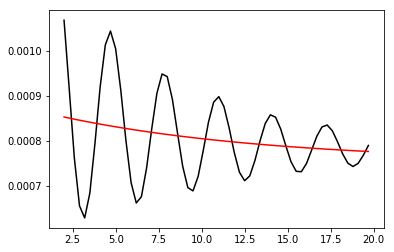

In [74]:
ramsey_fit = lambda t, a, Omega, Gamma, phi, c: a*np.exp(-Gamma*t)*np.cos(Omega*t+phi) + c
p0 = np.amax(peak_heights), (OmegaC1+OmegaC3)/(2*Delta), 1/20, 0, peak_heights[-1]
popt, pcov = cf(ramsey_fit, pulse_widths, peak_heights, p0=p0)
plt.plot(pulse_widths, peak_heights, '-k')
plt.plot(pulse_widths, ramsey_fit(pulse_widths, *popt), '-r')

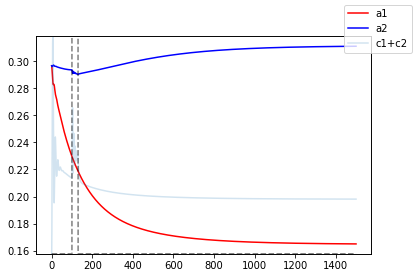

In [77]:
fig = plt.figure()
ax = fig.gca()
ax.plot(t, output.expect[0], '-r', label='a1')
ax.plot(t, output.expect[1], '-b', label='a2')

cts = output.expect[4]+output.expect[5]
ax2 = ax.twinx()
ax2.plot(t, cts, label='c1+c2', alpha=0.2)
ax2.plot(t, seqC3(t, pulse_args)*max(np.amax(output.expect[0]),np.amax(output.expect[1])), '--k', alpha=0.5)
ax2.set_ylim([0, np.amax(cts)])
ax2.set_yticks([])
ax2.set_yticklabels([])
fig.legend()
plt.show()